In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import metapredict as meta
from localcider.sequenceParameters import SequenceParameters
import os
from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from scipy.stats import hypergeom
import random
from scipy import stats
from tqdm import tqdm
from collections import Counter

curr_dir = os.getcwd()
meta_df = pd.read_csv(os.path.join(curr_dir,'csv_files/file_list.csv'),index_col =0)
res_folder_path = os.path.abspath(os.path.join(curr_dir,'../res_files'))
tiling_seqs = pd.read_csv(os.path.join(curr_dir,'supp_tables/Table_S2_Tiling.csv'),index_col=0)
tiling_seqs_nona = tiling_seqs.dropna(subset=['distanceFromFit'])

plt.rcParams["figure.autolayout"] = True
plt.rcParams['pdf.fonttype'] = 42

<font size="12">Functions</font>


In [47]:
def normTP0(df):
    '''This function normlizes to TP0'''
    fin_df = pd.DataFrame()
    bio_rep = list(map(lambda x: x.split('_')[0],df.columns.values)) #gets the bio rep of each column
    for br in np.unique(bio_rep):
        sub_df = df.iloc[:,[i for i,x in enumerate(bio_rep) if br==x]] #create a temp df of current bio reps columns
        zero_tp_loc = sub_df.columns.str.contains('_0') #get tp0
        sub_df = sub_df.sub(sub_df.loc[:,zero_tp_loc].values) #norm to tp0
        sub_df = sub_df.drop(sub_df.columns[np.where(zero_tp_loc)[0][0]],axis=1) #remove tp0
        fin_df = pd.concat([fin_df,sub_df],axis=1)
    return fin_df


def normReads(fileName,meta_df):
    '''This function normalize reads and remove bad samples'''
    #load experiment and normalize to num of reads
    folder_path = os.path.abspath(os.path.join(curr_dir,'../res_files'))
    df = pd.read_csv(os.path.join(folder_path, fileName),index_col=0)
    df_norm = np.log2((df.div(df.sum()) * 1000000) + 1)  
    
    #load sampleInfo.csv,remove bad samples, average repeats
    badSamples = meta_df.loc[meta_df["res_file_name"]==fileName]["bad_samples"].values[0]
    
    if badSamples == 'non':
        tp_index = df_norm.columns.str.split('_').str[0] + '_' + df_norm.columns.str.split('_').str[1]
        df_norm = df_norm.groupby(tp_index, axis=1).mean()
    elif badSamples == 'all':        
        print('bad experiment')         
    else:
        badSamples = [int(i) -1 for i in badSamples.split(',')] 
        df_norm = df_norm.drop(df_norm.iloc[:, badSamples],axis = 1)
        tp_index = df_norm.columns.str.split('_').str[0] + '_' + df_norm.columns.str.split('_').str[1]
        print('droping samples'+ str(badSamples))
        df_norm = df_norm.groupby(tp_index, axis=1).mean()
        
    return df_norm

def cal_GFP(df,lib_type,minNumReads,maxSTD):
    '''Load GFP data and calculate the mean GFP levels of each peptide'''
    #load FACS gating data
    if lib_type == 'Msn2T':                         
        df_gfp = pd.read_csv(os.path.abspath(os.path.join(curr_dir,'../res_files',('BY_TEF1_'+lib_type+'_GFP_HSP26_15.csv'))),index_col=0)
    elif lib_type == 'Pep3':
        df_gfp = pd.read_csv(os.path.abspath(os.path.join(curr_dir,'../res_files','Pep3_GFP_HSP26.csv')),index_col=0)
        dup_indices = [i for i, index in enumerate(df_gfp.index) if index == 'pep3']
        for i, idx in enumerate(dup_indices):
                df_gfp.index.values[idx] =  df_gfp.index.values[idx]+'_wt_'+str(i)
    else:
        df_gfp = pd.read_csv(os.path.abspath(os.path.join(curr_dir,'../res_files',('BY_TEF1_'+lib_type[0]+'_GFP_HSP26_16.csv'))),index_col=0)
    
    #load GFP sorting statistics
    GFP_stats = pd.read_csv(os.path.join(curr_dir,'csv_files','FACS_stats_allLibs.csv'),index_col='library')
    meanGFP = pd.DataFrame(GFP_stats.groupby('Population')['GFP-A Mean'].mean().sort_values(ascending=False))
    GFP_stats = GFP_stats.filter(regex=lib_type,axis=0)

    #remove columns of GFP data
    df = df.loc[:, ~df.columns.str.contains('GFP')]
    
    #load GFP sequencing data, normalize, average technical repeats
    df_gfp.index = df_gfp.index.str.replace('GAL11', 'MED15')
    df_gfp_norm = (df_gfp.div(df_gfp.sum()) * 1000000 )+1  #normalize to read count
    df_gfp_norm.index = df_gfp_norm.index.str.upper()
    df_gfp_norm[np.log2(df_gfp_norm)<minNumReads] = 0    #remove cells with low amount of reads
    
    #calculate GFP for each repeat seperately
    GFP_df = pd.DataFrame(index=df.index) 

    for rep in sorted(set(df_gfp.columns.str.split('_').str[2])):
        rep_data = df_gfp_norm[[col for col in df_gfp_norm.columns if col.endswith('_'+ rep)]]
        rep_data = rep_data.div(rep_data.sum(axis=1), axis=0)
        rep_data = rep_data * meanGFP['GFP-A Mean'].values * (1- GFP_stats['%Parent'].values/100)
        GFP_df['GFP_rep'+rep] = rep_data.sum(axis=1)
    for index, row in GFP_df.iterrows():
        if (row == 0).any(): 
            GFP_df.loc[index] = np.nan
    GFP_df.loc[np.std(GFP_df,axis=1) > maxSTD] = np.nan
    df = pd.concat([df,GFP_df],axis=1)     
    df['GFP_mean'] = GFP_df.mean(axis=1)
    df['GFPstd'] = np.std(GFP_df,axis=1)
    df['GFPsem'] = np.std(GFP_df,axis=1) / np.sqrt(GFP_df.shape[1])
    df['GFP_CV'] = np.std(GFP_df, axis=1) / np.mean(GFP_df,axis=1) * 100 
    return df, GFP_df, df_gfp_norm



def cal_dis_from_fit(df,parm1,parm2):
    '''calulate distance of each point from linear regression'''
    df_noNA = df[[parm1, parm2]].copy().dropna()
    x = df_noNA[parm1].values[:,np.newaxis]
    y = df_noNA[parm2]
    model = LinearRegression().fit(x, y)
    df_noNA['distanceFromFit']  = y - model.predict(x)
    df.loc[df_noNA.index,'distanceFromFit'] = df_noNA['distanceFromFit'] 
    slope = model.coef_[0]
    return df, model

def rotate_axis(df,parm1,parm2):
    '''Perform centroid rotation acordding to the regression slope'''
    
    _, model_reg  = cal_dis_from_fit(df,parm1,parm2) #calculate regression
    # Calculate centroid of the data
    x = df[parm1]
    y = df[parm2]
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)

    angle = model_reg.coef_ * -1 # Calculate angle of rotation to make the regression line horizontal
    
    # Rotate the data points around the centroid
    df[parm1+'_rotated'] = (x - centroid_x) * np.cos(angle) - (y - centroid_y) * np.sin(angle) + centroid_x
    df[parm2+'_rotated'] = (x - centroid_x) * np.sin(angle) + (y - centroid_y) * np.cos(angle) + centroid_y
    return df

def remove_similar_peps(df,distance):
    '''This function remove overlappinig peptides (defined by 'distance') from the same TF, keeping the best binding peptides'''
    unique_pep_names = list(set([name.split('_')[0] for name in df.index]))
    res_df = pd.DataFrame(columns = df.columns)
    
    for name in unique_pep_names:
        temp_df = df[df.index.str.contains(name)].dropna(subset=['distanceFromFit'])
        if len(temp_df)>1: 
            temp_df = temp_df.copy()
            temp_df['start'] = temp_df.index.str.split('_').str[1].astype(int)
            temp_df = temp_df.sort_values('start')
            temp_df['GroupId'] = temp_df.start.diff().gt(distance).cumsum() + 1
            out_df = temp_df.loc[temp_df.groupby('GroupId')['distanceFromFit'].idxmin()]
            out_df.drop(columns=['start','GroupId'], inplace=True)

        else:
            out_df = temp_df
        res_df = pd.concat([res_df,out_df],axis=0)
    
    return res_df 

def cal_mean_disorder(sequence, AA_disorder_df, normVal=None):
    
    total_disorder = []
    if pd.notna(sequence) and len(sequence) > 40:
        
        for pos in sequence:
            total_disorder.append(AA_disorder_df.loc[AA_disorder_df['residue'] == pos, 'Disorder propensity'].values[0])
        if normVal is not None:      
            mean_disorder = sum(total_disorder) / len(total_disorder) * normVal
        else:
            mean_disorder = sum(total_disorder) / len(total_disorder)
    else:
        mean_disorder = np.nan
    return mean_disorder

def cal_len_disorder(seq,threshold):
    current_stretch_length = 0
    max_stretch_length = 0

    for value in seq:
        if value > threshold:
            current_stretch_length += 1
            if current_stretch_length > max_stretch_length:
                max_stretch_length = current_stretch_length
        else:
            current_stretch_length = 0

    return max_stretch_length 


def markDomains(tf,ax):
    domain_locs_df = pd.read_csv(os.path.join(curr_dir,'csv_files/tf_domains_plot.csv'),index_col =0).reset_index()
    domain_locs_df_sub = domain_locs_df[domain_locs_df['protein'].str.contains(tf)]    
    for index, row in domain_locs_df_sub.iterrows():
        ax.axvspan(int(row['start']), int(row['end']), facecolor=row['color'], alpha=0.3, label=row['domain'])
        ax.text(int(row['start'])+1, ax.get_ylim()[1]-0.1, row['domain'], fontsize = 8, color = row['color'])

        #function to calcaule localCider parameters

def calculate_cider_parameters(df, seq_col):
    attributes = [
        'get_fraction_disorder_promoting',
        'get_FCR',
        'get_Omega',
        'get_PPII_propensity',
        'get_WW_hydropathy',
        'get_NCPR',
        'get_countNeg',
        'get_countNeut',
        'get_countPos',
        'get_delta',
        'get_deltaMax',
        'get_fraction_expanding',
        'get_fraction_negative',
        'get_fraction_positive',
        'get_isoelectric_point',
        'get_kappa',
        'get_kappa_after_phosphorylation',
        'get_uversky_hydropathy',
        'get_mean_net_charge'

    ]

    results = {attr[4:]: [] for attr in attributes}  # Remove 'get_' prefix

    for sequence in tqdm(df[seq_col], desc="Processing sequences", unit="sequence"):
        if pd.notna(sequence) and len(sequence) > 40:
            seq_ob = SequenceParameters(sequence)
            for attr in attributes:
                method = getattr(seq_ob, attr)
                results[attr[4:]].append(method())
        else:
            for key in results:
                results[key].append(np.nan)

    res_df = pd.DataFrame(results, index=df.index)
    return res_df


def load_iupred(folder_path): #load iupred data and calculate mean
    mean_values = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('_iupred_short.dis'):
            index = filename.split('_iupred_short.dis')[0]
            file_path = os.path.join(folder_path, filename)
            
            with open(file_path, 'r') as file:
                array = np.loadtxt(file,usecols=[2])
                mean_value = np.mean(array)
                
            mean_values[index] = mean_value
    
    return pd.DataFrame.from_dict(mean_values, orient='index', columns=['iupred'])

def tf_length(df): #calculate the length of each tf
    tf_names = df['TF_name'].unique()
    tf_length = []
    for tf in tf_names:
        sub_df = df[df['TF_name'] == tf]
        tf_length.append(sub_df['pep_end'].max())
    return pd.DataFrame(tf_length,index=tf_names,columns=['length'])


def count_aas_groups(seq):
    res_dict = {}
    aa_groups = [['K','R'],['E','D'],['F','W','Y'],['L','I','V','M'],['N','Q'],['S','T'],['G','P']]
    aa_list = ['K','R','E','D','F','Y','W','L','I','V','M','N','Q','S','T','G','P','C','A','H']

    aa_count = pd.DataFrame(Counter(seq),index=['AA']).T
    all_aas = pd.DataFrame(np.zeros(len(aa_list)),index=aa_list)
    all_aas.loc[aa_count.index] = aa_count
    for aas in aa_groups:
        res_dict[''.join(aas)] = all_aas.loc[aas].sum().values[0]
    return res_dict

def count_amino_acids(sequence):
    return {aa: sequence.count(aa) for aa in amino_acids}


<font size="12">Plots</font>


In [35]:
meta_df = pd.read_csv(os.path.join(curr_dir,'csv_files/file_list.csv'),index_col =0)
csv_files = sorted(os.listdir(res_folder_path), key=str.casefold)
tp='360'

tiling_csv = [x for x in csv_files if 'BY_TEF1_T_' in x]
tiling_csv = [item for item in tiling_csv if "GFP" not in item and "promUpstream" not in item and "YAP6" not in item]

tiling_df = pd.DataFrame()

for x in tiling_csv: 
    df = normReads(x, meta_df)
    df = normTP0(df)
    df = df.add_prefix(x[:-4].split('_')[4] + '_' + x[:-4].split('_')[5] + '_')
    tiling_df = pd.concat([tiling_df,df],axis=1)
tiling_df = tiling_df.filter(regex=tp)
tiling_df.index = tiling_df.index.str.replace('GAL11', 'MED15')
# DomainDesc = rotate_axis(DomainDesc,'GFP_mean','median_FC')


droping samples[0]
droping samples[4, 6]
droping samples[5]
droping samples[2]
droping samples[1, 4]


<Axes: >

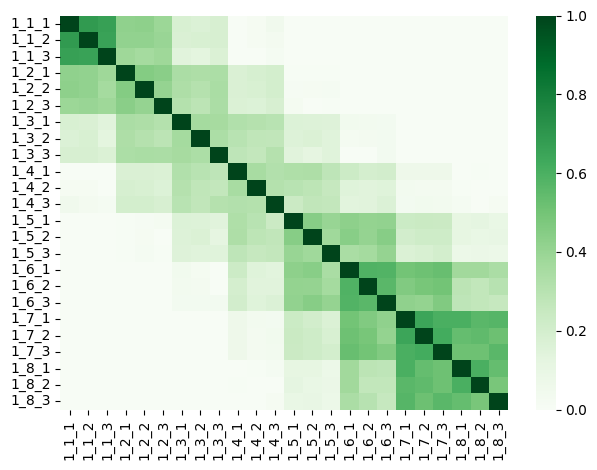

In [36]:
_,_, df_gfp_norm = cal_GFP(tiling_seqs,'Tiling',4,1000)
sns.heatmap(df_gfp_norm.corr(),cmap='Greens',vmin=0)
# plt.savefig('/home/labs/barkailab/offirlu/pepLib/Paper/Fig3/SUPP/GFPcorr.pdf', format="pdf", bbox_inches="tight")

0.5798592145769461

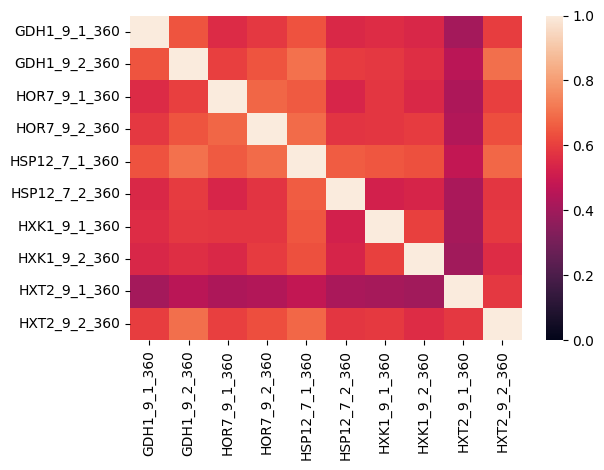

In [37]:

sns.heatmap(tiling_df.loc[tiling_seqs_nona.index].corr(),vmin=0,vmax=1)
corr_df = tiling_df.loc[tiling_seqs_nona.index]
# Dictionary to store correlations
pairwise_correlations = []

prefixes = set(col.split('_')[0] for col in corr_df.columns)
for prefix in prefixes:
    cols = [col for col in corr_df.columns if col.startswith(prefix)]
    if len(cols) == 2:
        correlation = corr_df[cols[0]].corr(corr_df[cols[1]])
        pairwise_correlations.append(correlation)
np.median(pairwise_correlations)

full_corr_matrix = corr_df.corr()

# Exclude correlations between columns with the same prefix
for prefix in prefixes:
    cols = [col for col in corr_df.columns if col.startswith(prefix)]
    if len(cols) == 2:
        full_corr_matrix.at[cols[0], cols[1]] = None
        full_corr_matrix.at[cols[1], cols[0]] = None

full_corr_matrix[full_corr_matrix == 1] = np.nan
np.nanmedian(full_corr_matrix.melt()['value'])

(-3.0, 2.0)

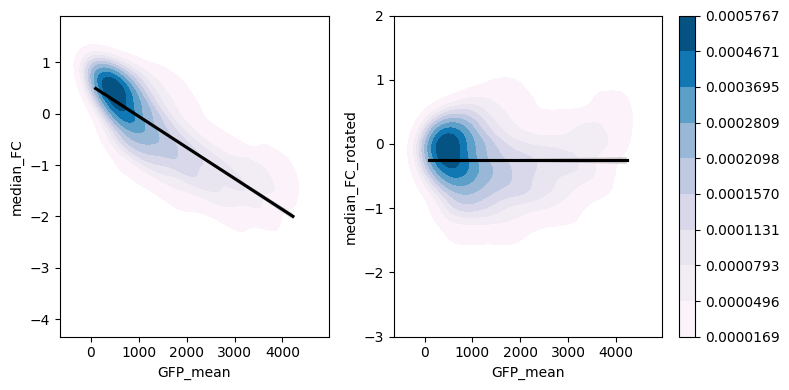

In [38]:
fig,axes = plt.subplots(1,2,figsize=(8,4),width_ratios=[4,5])
sns.kdeplot(data = tiling_seqs,x = 'GFP_mean',y="median_FC",cmap='PuBu',fill=True,ax=axes[0])
sns.regplot(data=tiling_seqs, x="GFP_mean", y="median_FC",color='k',scatter=False,ax=axes[0])

sns.kdeplot(data = tiling_seqs,x = 'GFP_mean',y="median_FC_rotated",cmap='PuBu',fill=True, cbar=True,ax=axes[1])
sns.regplot(data=tiling_seqs, x="GFP_mean", y="median_FC_rotated",color='k',scatter=False,ax=axes[1])
plt.ylim(-3,2)



Text(0.5, 1.0, 'FC')

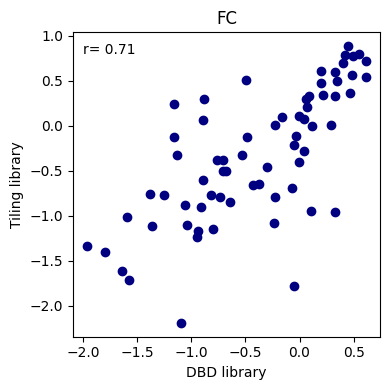

In [26]:

res_df = pd.DataFrame()

domain_included = []
DomainDesc = pd.read_csv(os.path.join(curr_dir,'supp_tables/Table_S1_Domains.csv'),index_col=0)
DomainDesc = remove_similar_peps(DomainDesc,20)
DomainDesc['pep_start'] = DomainDesc.index.str.split('_').str[1].astype(int)
DomainDesc['pep_end'] = DomainDesc.index.str.split('_').str[2].astype(int)


for i, row in DomainDesc.iterrows():   
    sub_tiling_df = tiling_seqs_nona[tiling_seqs_nona['TF_name'] == row['TF_name']]
    closest_row = sub_tiling_df.loc[(np.abs(sub_tiling_df['pep_start'] - row['pep_start'])).idxmin()]
    if closest_row['pep_start']  < row['OriginalStartPos'] and closest_row['pep_end']> row['OriginalEndPos']:
        domain_included.append(1)
    else:
        domain_included.append(0)
        
    a = pd.DataFrame({'Domain pep': [row.name], 'FC_Domain' : [row['median_FC']], 'tiling pep': [closest_row.name], 'FC_tiling' : [closest_row['median_FC']],
                      'dis_from_fit_domain': [row['distanceFromFit']], 'dis_from_fit_tiling' : [closest_row['distanceFromFit']],
                      'GFP_domain' : [row['GFP_mean']], 'GFP_tiling' : [closest_row['GFP_mean']]})   
    res_df = pd.concat([res_df, a],axis=0)
    
res_df = res_df.reset_index().drop(columns='index')
res_df = pd.concat([res_df,pd.DataFrame(domain_included,columns=['domain_included'])],axis=1)

res_df['distance'] = np.abs(res_df['Domain pep'].apply(lambda x: int(x.split('_')[1]))  - res_df['tiling pep'].apply(lambda x: int(x.split('_')[1])))
res_df = res_df[res_df['domain_included'] == 1]
res_df = res_df[res_df['distance'] < 6]


fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(res_df['FC_Domain'],res_df['FC_tiling'],c='Navy')
ax.text(-2,0.8,'r= ' + str(round(res_df['FC_Domain'].corr(res_df['FC_tiling']),2)))
ax.set_xlabel('DBD library')
ax.set_ylabel('Tiling library')
ax.set_title('FC')


(-1.0, 1.0)

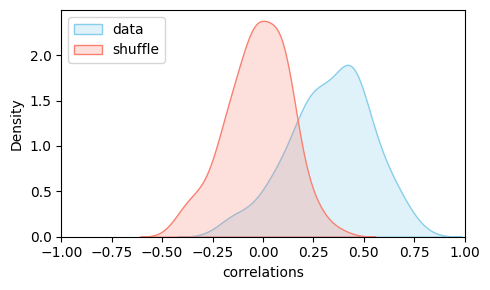

In [39]:
#auto correlation
tresh_numPeps = 20
lag = 1

correlations = []
random_corr = []
tfs = []
all_tfs = tiling_seqs['TF_name'].value_counts().index.to_list()

for tf in all_tfs:
    sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == tf.upper()].sort_values(by='pep_start')
    #take only rows sequental values 
    sub_tiling_df = pd.concat([sub_tiling_df,pd.DataFrame(sub_tiling_df['pep_start'].diff().abs()).rename(columns={'pep_start': 'deltaStart'})],axis=1)
    sub_tiling_df = sub_tiling_df[sub_tiling_df['deltaStart'] < 25]
    if len(sub_tiling_df) >tresh_numPeps:
        correlation = np.corrcoef(sub_tiling_df['median_FC'][:-lag], sub_tiling_df['median_FC'][lag:])
        correlations.append(correlation[0, 1])
        tfs.append(tf)
        clist = sub_tiling_df['median_FC'].values.copy()
        random.shuffle(clist)
        curr_scram = []
        correlation = np.corrcoef(clist[:-lag],clist[lag:])
        random_corr.append(correlation[0, 1])
            
            
fig,ax = plt.subplots(1,1,figsize = (5,3))
df = pd.DataFrame({'correlations':correlations,'random_correlations' : random_corr},index=tfs)
df = df.dropna()
sns.kdeplot(df['correlations'], color='skyblue', fill=True)
sns.kdeplot(df['random_correlations'], color='salmon', fill=True)

# ttestVal = stats.ttest_ind(a=df['correlations'], b=df['random_correlations'], equal_var=True)
# plt.title('lag= ' + str(lag) + ' pValue= ' + str(ttestVal.pvalue))
plt.legend(labels=['data','shuffle'],loc =2)
plt.xlim(-1,1)


<font size="12">Examine strongest peptides tiling</font>


In [68]:
#add TF family
# DomainDesc = pd.read_csv('/home/labs/barkailab/offirlu/pepLib/DomainDesc_wProp.csv').set_index('Pep_name').drop(columns=['median_FC'])


#find if a peptide is interproDomain
tf_family = []
domains_desc = []
domains_general_desc = []

#add interpro data
interpro_df = pd.read_csv(os.path.join(curr_dir,'csv_files/interPro_domains_filtered.csv'),index_col=0)

for i,row in tiling_seqs.iterrows():
    sub_interpro = interpro_df[interpro_df['TF'] == row['TF_name']]
    sub_domain = DomainDesc[DomainDesc['TF_name'] == row['TF_name']]
    
    if not sub_interpro.empty:
        #find closelst domain
        closelst_domain = sub_interpro.loc[pd.DataFrame(np.abs(row['pep_start']  - sub_interpro['start'])).idxmin()[0],:]
        if row['pep_start']  < (closelst_domain['stop'] -  closelst_domain['length']/2) and row['pep_end'] > (closelst_domain['start'] + closelst_domain['length']/2):
            domains_desc.append(closelst_domain['description'])
            domains_general_desc.append(closelst_domain['general_description'])
        else:
            domains_desc.append('no annotation')
            domains_general_desc.append('no annotation')
    else:
        domains_desc.append('no annotation')
        domains_general_desc.append('no annotation')
        
tiling_seqs['interpro_general_description'] = domains_general_desc        
tiling_seqs['interpro_description'] = domains_desc




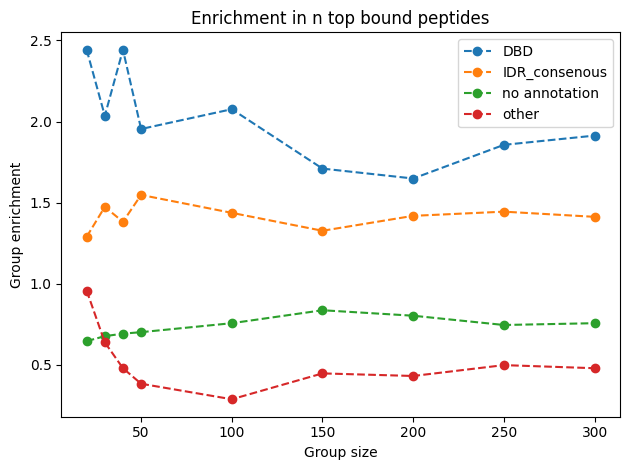

/tmp/ipykernel_53480/3984731581.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(res_df[100],palette=colors)


<Axes: xlabel='interpro_general_description', ylabel='100'>

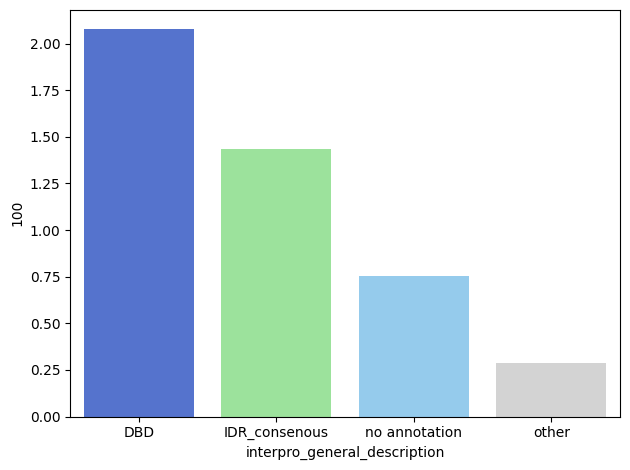

In [69]:
# numPeps = [100]
tiling_seqs_nona = tiling_seqs.dropna(subset=['distanceFromFit'])

numPeps = [20,30,40,50,100,150,200,250,300]

res_df = pd.DataFrame()
for numPep in numPeps:
    top_fration = pd.DataFrame(tiling_seqs_nona.sort_values(by="distanceFromFit").iloc[0:numPep].groupby('interpro_general_description')['distanceFromFit'].count()/numPep)
    general_fraction = pd.DataFrame(tiling_seqs_nona['interpro_general_description'].value_counts()/tiling_seqs_nona.shape[0])
    ratios_df = pd.concat([top_fration, general_fraction],axis=1)
    ratio = pd.DataFrame(ratios_df['distanceFromFit'] / ratios_df['count'] ).rename(columns={0: numPep})
    res_df = pd.concat([res_df, ratio],axis=1)

plt.plot(res_df.T, marker='o', linestyle='dashed')
plt.ylabel('Group enrichment')
plt.xlabel('Group size')
plt.title('Enrichment in n top bound peptides')
plt.legend(res_df.T.columns)
plt.show()

colors = [ 'royalblue', 'lightgreen','lightskyblue', 'lightgrey']
sns.barplot(res_df[100],palette=colors)
#add if its a DBD
# isDBD = []
# #
# for i,row in tiling_seqs.iterrows():
#     curr_dbd = DomainDesc[DomainDesc['TF_name'] == row['TF_name']]
#     if not curr_dbd.empty:
#         curr_dbd_len = curr_dbd['OriginalEndPos'][0] - curr_dbd['OriginalStartPos'][0]
#         if row['pep_start']  < (curr_dbd['OriginalEndPos'][0] - curr_dbd_len/2) and row['pep_end']> (curr_dbd['OriginalStartPos'][0] + curr_dbd_len/2):
#             isDBD.append(1)
#         else:
#             isDBD.append(0)
#     else:
#         isDBD.append(0)
# tiling_seqs['isDBD_loc'] = isDBD

In [70]:
amino_acids = ['L','I','V','M','F','W','Y','A', 'D', 'E', 'K', 'R', 'H', 'C', 'G','P', 'N', 'Q', 'S', 'T']
numPep = 100

## This take about 10 minutes to run ##
#tiling_cider_df = calculate_cider_parameters(tiling_seqs[tiling_seqs['distanceFromFit'].notna()],'Pep_seq') 
##

tiling_cider_df = pd.read_csv(os.path.join(curr_dir,'csv_files/tiling_cider.csv'),index_col=0)
tiling_seqs_nona['iupred'] = tiling_cider_df.loc[tiling_seqs_nona.index,'iupred']

# Create a new DataFrame to store the counts
counts_df = pd.DataFrame(amino_acids)



/tmp/ipykernel_53480/1702660498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiling_seqs_nona['iupred'] = tiling_cider_df.loc[tiling_seqs_nona.index,'iupred']


(0.0, 12.0)

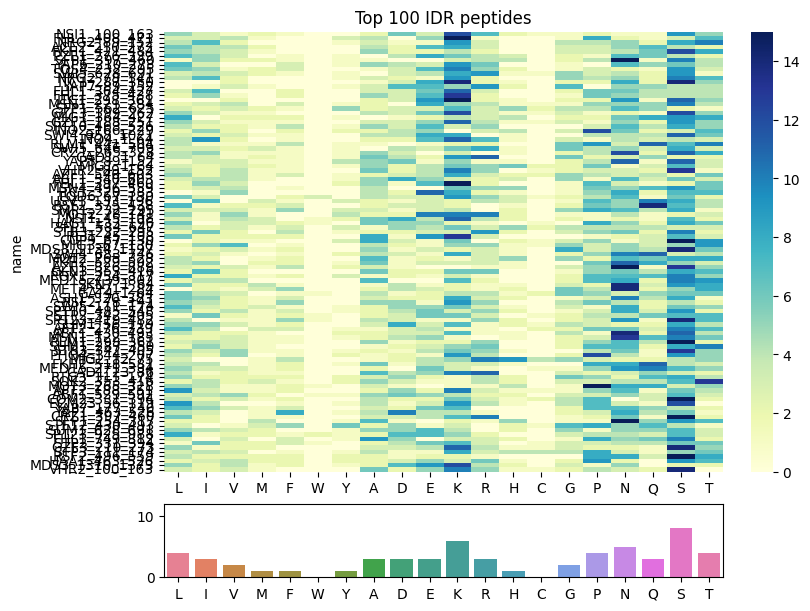

In [59]:
#top 100

df = tiling_seqs_nona[tiling_seqs_nona['iupred'] >.5].sort_values(by="distanceFromFit",ascending=True).iloc[0:numPep]
counts_df = df['Pep_seq'].apply(count_amino_acids).apply(pd.Series) # Apply the function to each sequence and create a new DataFrame

best_tils_aacounts = counts_df.median()
fig,ax = plt.subplots(2,1,figsize=(8,6),height_ratios=[6,1],constrained_layout=True)
sns.heatmap(counts_df,cmap='YlGnBu',vmax=15,yticklabels=True,ax=ax[0])
ax[0].set_title('Top ' + str(numPep) + ' IDR peptides') 
sns.barplot(pd.DataFrame(counts_df.median(axis=0)).T,ax=ax[1])
plt.ylim([0,12])



(0.0, 12.0)

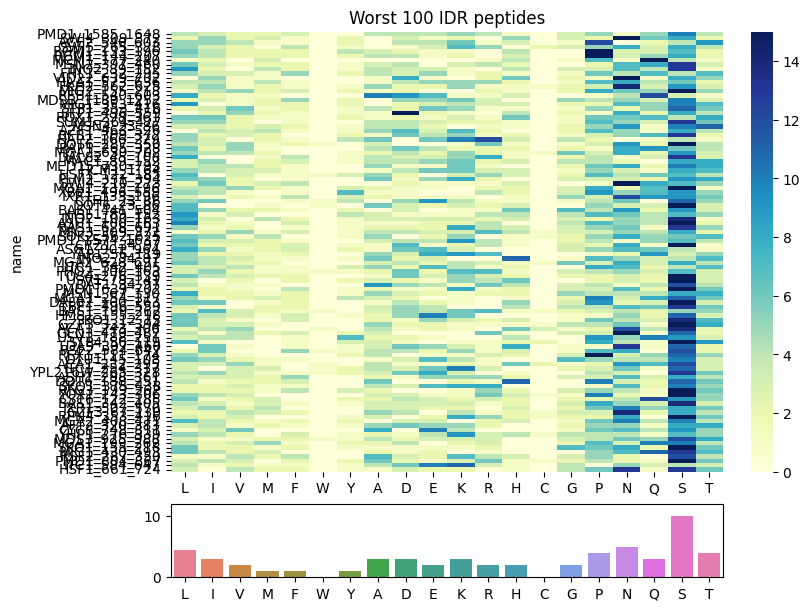

In [60]:
#bottom 100

df = tiling_seqs_nona[tiling_seqs_nona['iupred'] >.5].sort_values(by="distanceFromFit",ascending=False).iloc[0:numPep]
# Apply the function to each sequence and create a new DataFrame
counts_df = df['Pep_seq'].apply(count_amino_acids).apply(pd.Series)
worst_tils_aacounts = counts_df.median()

fig,ax = plt.subplots(2,1,figsize=(8,6),height_ratios=[6,1],constrained_layout=True)
sns.heatmap(counts_df,cmap='YlGnBu',vmax=15,yticklabels=True,ax=ax[0])
ax[0].set_title('Worst ' + str(numPep) + ' IDR peptides') 
sns.barplot(pd.DataFrame(counts_df.median(axis=0)).T,ax=ax[1])
plt.ylim([0,12])



Text(0, 0.5, 'delta Top-bottom')

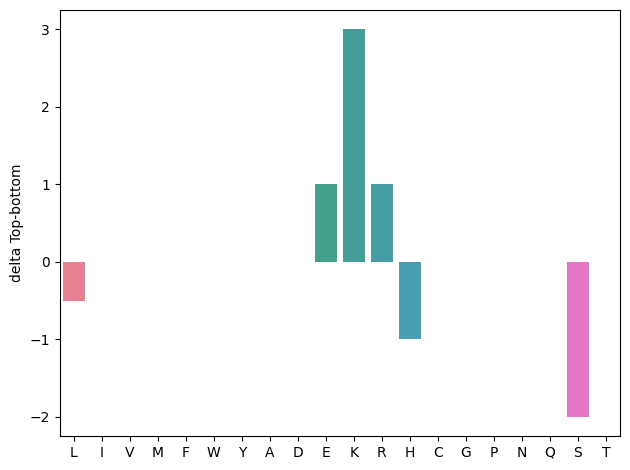

In [61]:
sns.barplot(pd.DataFrame(best_tils_aacounts-worst_tils_aacounts).T)
plt.ylabel('delta Top-bottom')

In [71]:

#do hyper geometric test for group enrichment
numPep = 100
group='DBD' 
# group='IDR_consenous'
x = tiling_seqs_nona.sort_values(by="distanceFromFit").iloc[0:numPep].groupby('interpro_general_description')['distanceFromFit'].count()[group]
n = tiling_seqs_nona['interpro_general_description'].value_counts()[group]

pval = hypergeom.sf(x, tiling_seqs_nona.shape[0], n, numPep)
pval

0.0010512260865485205

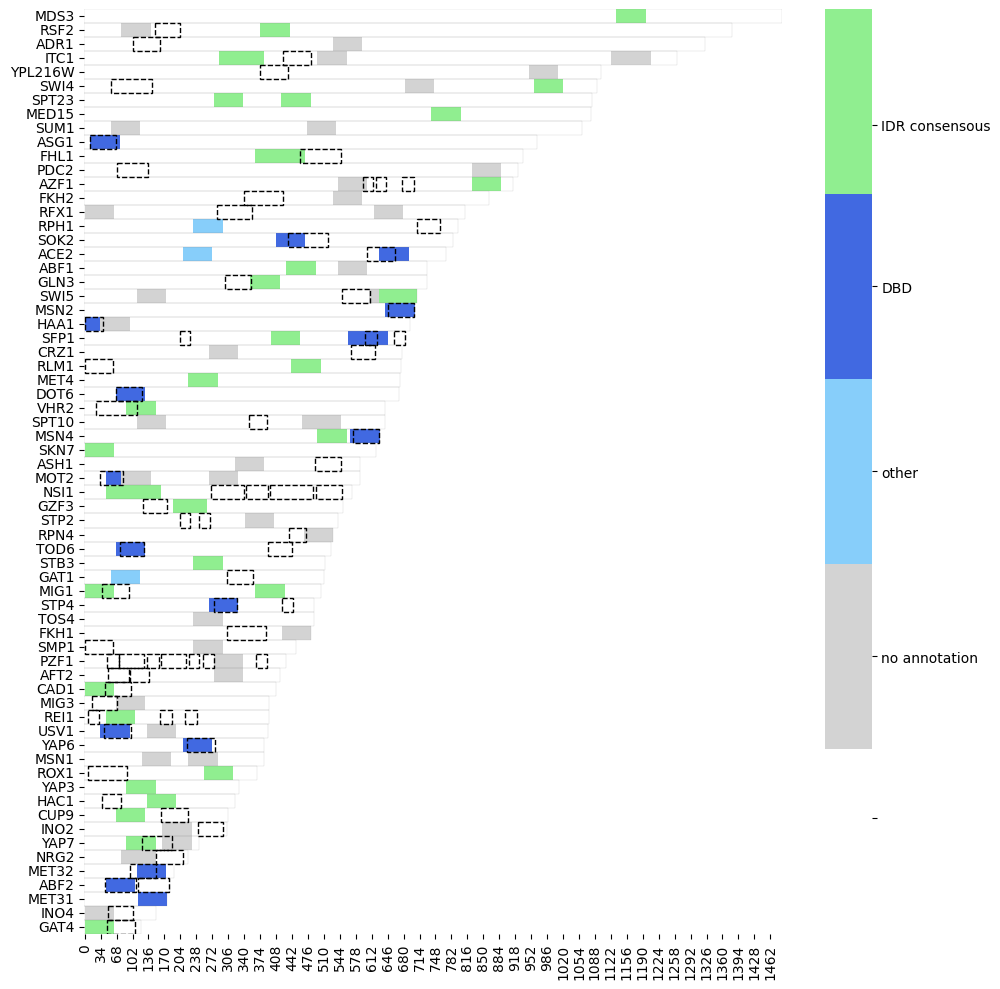

In [72]:
#Taking top tiles and build a map of their TFs

Domains_DBDonly = DomainDesc[DomainDesc['is_DBD'] == 1]
nTopTiles = 100
all_tfs = tf_length(tiling_seqs).sort_values(by='length',ascending=False).index.to_list()
topTbound  = tiling_seqs.sort_values(by='distanceFromFit').iloc[:nTopTiles]
all_tfs_top = topTbound.sort_values(by='distanceFromFit')[:nTopTiles]['TF_name'].unique()
treshold = topTbound['distanceFromFit'].max()

all_tfs = [value for value in all_tfs if value in all_tfs_top]

colors = ['white', 'lightgrey', 'lightskyblue', 'royalblue', 'lightgreen']
cmap = ListedColormap(colors)

tf_dict = dict()
domain_dict = dict()
x_corr = []
y_corr = []
width_len = []
interpro_domain = []

max_size = tiling_seqs[tiling_seqs['TF_name'] == 'MDS3']['pep_end'].max() #RSF2, longest TF

# all_tfs = ['MSN2','MSN2']
c=0
for c, tf in enumerate(all_tfs):

    sub_df = tiling_seqs[tiling_seqs['TF_name'] == tf] 
    tf_array = np.zeros(sub_df['pep_end'].max())
    # tf_length = sub_df['pep_end'].max()
    tf_array = np.append(tf_array, np.full(max_size - len(tf_array), np.nan))
    sub_top_til = sub_df[sub_df['distanceFromFit'] <= treshold]
    for i, row in sub_top_til.iterrows():
        if row['interpro_general_description'] == 'no annotation':
            tf_array[int(row['pep_start']):int(row['pep_end'])] = 1   
        elif row['interpro_general_description'] == 'other':
            tf_array[int(row['pep_start']):int(row['pep_end'])] = 2
        elif row['interpro_general_description'] == 'DBD':    
            tf_array[int(row['pep_start']):int(row['pep_end'])] = 3
        elif row['interpro_general_description'] == 'IDR_consenous':    
            tf_array[int(row['pep_start']):int(row['pep_end'])] = 4            
    tf_dict[tf] = pd.Series(tf_array)
    
    #dbd annototation
    dbdonly_sub_df = Domains_DBDonly[Domains_DBDonly['TF_name'] == tf]
    if not dbdonly_sub_df.empty:
        for i, row in dbdonly_sub_df.iterrows():
            x_corr.append(row['OriginalStartPos'])
            width_len.append(row['OriginalEndPos'] - row['OriginalStartPos'])
            y_corr.append(c)

dbd_df = pd.DataFrame({'x_corr' : x_corr, 'y_corr' : y_corr, 'width_len' : width_len})    
df = pd.DataFrame(tf_dict)
df = df.T
fig,axes = plt.subplots(1,1,figsize=(10,10))
hm = sns.heatmap(df,yticklabels=True,cmap=cmap,cbar_kws={'ticks': [0.5, 1.2, 2, 2.8, 3.5]})
hm.collections[0].colorbar.set_ticklabels(['','no annotation','other','DBD','IDR consensous'])

for i, row in df.reset_index().iterrows():
    non_nan_indices = [idx for idx, val in enumerate(row) if not pd.isna(val)]
    start_index = min(non_nan_indices)
    end_index = max(non_nan_indices)-1
    rect = plt.Rectangle((start_index, i), end_index - start_index + 1, 1, fill=False, edgecolor='grey', lw=.1)
    plt.gca().add_patch(rect)
# plt.xticks(ticks=ax.get_xticks(), labels=[int(np.round(newLabel*32 - ((newLabel-1)*32) +  ((newLabel-1)*11))) for newLabel in ax.get_xticks()])
plt.xticks(rotation=90)

        
for row in dbd_df.iterrows():
    rect = patches.Rectangle((row[1]['x_corr'], row[1]['y_corr']),row[1]['width_len'], 1,lw=1,linestyle = 'dashed' ,edgecolor='k', facecolor='none')
    # rect = patches.Rectangle((row[1]['x_corr'], row[1]['y_corr']),row[1]['width_len'], 1,lw=1,linestyle = 'dashed' , facecolor='salmon')
    hm.add_patch(rect)

plt.show()


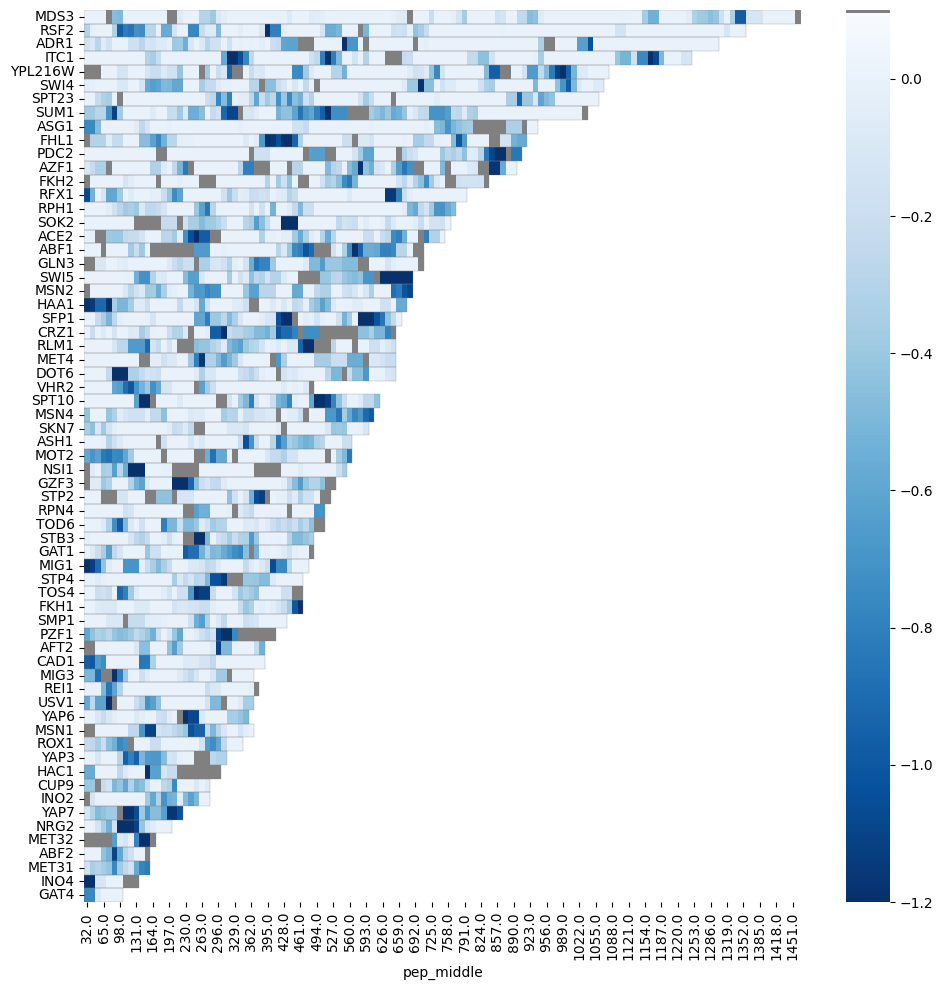

In [73]:

cmax = 0
cmin = -1.2

tf_dict = dict()
domain_dict = dict()
x_corr = []
y_corr = []
width_len = []
interpro_domain = []

orig_map = plt.get_cmap('Blues_r')
colors =  [orig_map(i) for i in range(orig_map.N)] + [(0.5, 0.5, 0.5)]
new_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("Blues_with_grey", colors)
reversed_map = orig_map.reversed()


all_tfs.remove('MED15')
c=0
for c, tf in enumerate(all_tfs):

    sub_df = tiling_seqs[tiling_seqs['TF_name'] == tf] 
    tf_array = np.zeros(sub_df['pep_end'].max())
    tf_array = np.append(tf_array, np.full(max_size - len(tf_array), np.nan))
    
    averages = pd.Series(sub_df['distanceFromFit']).rolling(window=3, min_periods=1,center=True).mean()
    averages[averages>cmax] = cmax
    averages = averages.fillna(cmax+ 0.1)
    averages = pd.DataFrame(averages).rename(columns={'distanceFromFit' : tf})
    tf_dict[tf] = pd.Series(averages.T.values[0])
    domain_dict[tf] = topTbound[topTbound['TF_name'] == tf]['interpro_general_description'].unique()
            
                 
dbd_df = pd.DataFrame({'x_corr' : x_corr, 'y_corr' : y_corr, 'width_len' : width_len})    
df = pd.DataFrame(tf_dict)
df = df.T
df.columns = tiling_seqs[tiling_seqs['TF_name'] == 'MDS3']['pep_middle']
fig,axes = plt.subplots(1,1,figsize=(10,10))
ax = sns.heatmap(df,yticklabels=True,cmap=new_cmap,vmin=cmin,vmax=cmax+0.1)
ax.collections[0].cmap.set_bad('w')


for i, row in df.reset_index().iterrows():
    non_nan_indices = [idx for idx, val in enumerate(row) if not pd.isna(val)]
    start_index = min(non_nan_indices)
    end_index = max(non_nan_indices)-1
    rect = plt.Rectangle((start_index, i), end_index - start_index + 1, 1, fill=False, edgecolor='grey', lw=.2)
    plt.gca().add_patch(rect)
plt.xticks(rotation=90)
plt.show()


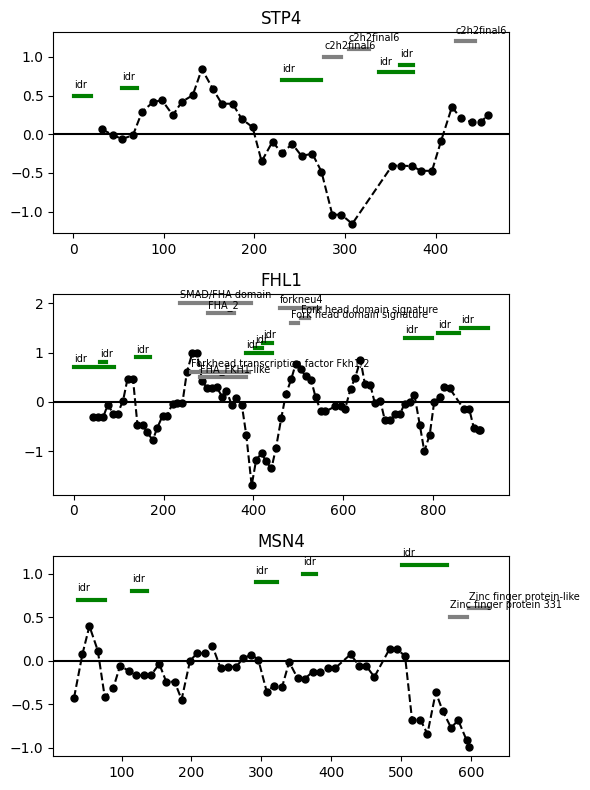

In [74]:
window_size=3
topTbound  = tiling_seqs.sort_values(by='distanceFromFit').iloc[:100]

tfs =['STP4','FHL1','MSN4']
fig,axes  = plt.subplots(len(tfs),1,figsize=(6,8))
for i,tf in enumerate(tfs):

    sub_topTbound = topTbound[topTbound['TF_name'] == tf.upper()]
    sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == tf.upper()].sort_values(by='pep_middle')
    sub_tiling_df['pep_middle'] = np.round((sub_tiling_df.index.str.split('_').str[2].values.astype(int) + sub_tiling_df.index.str.split('_').str[1].values.astype(int) )/2)
    sub_tiling_df = sub_tiling_df.sort_values(by='pep_middle')
    dom_sub_df = DomainDesc.loc[DomainDesc['TF_name'] == tf]
    sub_interpro = interpro_df.loc[interpro_df['TF'] == tf].sort_values(by='database')
    
    curr_ax = axes.ravel()[i]
    y_value = pd.Series(sub_tiling_df['distanceFromFit']).rolling(window=window_size, min_periods=1,center=True).mean()
    ind = ~np.isnan(np.asarray(y_value.astype(float)))
    curr_ax.plot(sub_tiling_df['pep_middle'][ind],y_value[ind],c='k',marker='o',linestyle='dashed', markersize = 5)        
    curr_ax.axhline(y=0,c='k')
    curr_ax.set_title(tf)
    markDomains(tf.upper(),curr_ax)

    k = .5
    for index, row in sub_interpro.iterrows():
        
        if row['database'] == 'MobiDBLite':
            curr_ax.plot([int(row['start']), int(row['stop'])],[k,k], c='green',linewidth=3)
            curr_ax.text(int(row['start']),k+.1,'idr',fontsize=7)
        else:
            curr_ax.plot([int(row['start']), int(row['stop'])],[k,k], c='grey',linewidth=3)
            curr_ax.text(int(row['start']),k+.1,row['description'],fontsize=7)
        k = k+.1
   

<font size="12">Figure 4  - correlation with sequence features</font>


Text(0, 0.5, 'Pearson r')

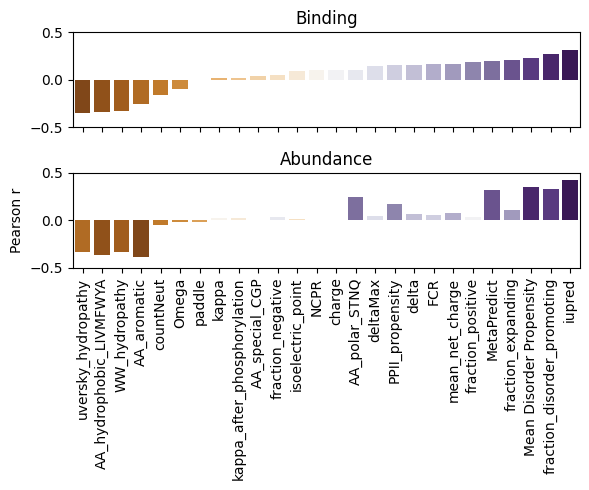

In [75]:

## This take about 10 minutes to run
#tiling_cider_df = calculate_cider_parameters(tiling_seqs[tiling_seqs['distanceFromFit'].notna()],'Pep_seq') 
##
tiling_cider_df = pd.read_csv(os.path.join(curr_dir,'csv_files/tiling_cider.csv'),index_col=0)
tiling_cider_df['distanceFromFit'] = tiling_seqs['distanceFromFit']* -1
tiling_cider_df['GFP_mean'] = tiling_seqs['GFP_mean']
tiling_cider_df['charge'] = (tiling_seqs['Pep_seq'].str.count('K') + tiling_seqs['Pep_seq'].str.count('R') - tiling_seqs['Pep_seq'].str.count('D') - tiling_seqs['Pep_seq'].str.count('E'))


a =  pd.DataFrame(tiling_cider_df.drop(columns=['Pep_seq']).corr()['distanceFromFit'].sort_values()[:-1]).T
b = pd.DataFrame(tiling_cider_df.drop(columns=['Pep_seq']).corr()['GFP_mean'].sort_values()[:-1]).T
df = pd.concat([a,b]).drop(columns=['distanceFromFit','GFP_mean']).T.reset_index().melt(id_vars=['index'])

fig,ax  = plt.subplots(2,1,figsize=(6,5),sharex=True,sharey=True)
sns.barplot(data=a.drop(columns=['GFP_mean']),ax=ax[0],palette='PuOr')
sns.barplot(data=b.drop(columns=['distanceFromFit']),ax=ax[1],palette='PuOr')
ax[0].set_ylim([-.5,.5])
ax[0].set_title('Binding')

ax[1].set_title('Abundance')

plt.xticks(rotation=90)
plt.ylabel('Pearson r')


<Axes: xlabel='paddle', ylabel='distanceFromFit'>

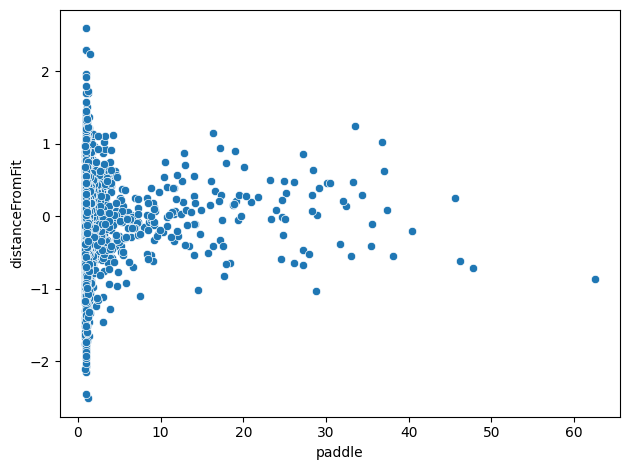

In [77]:
tiling_cider_df['distanceFromFit'] = tiling_seqs['distanceFromFit']
sns.scatterplot(data = tiling_cider_df.loc[tiling_cider_df['paddle']>=0], x='paddle',y = 'distanceFromFit')


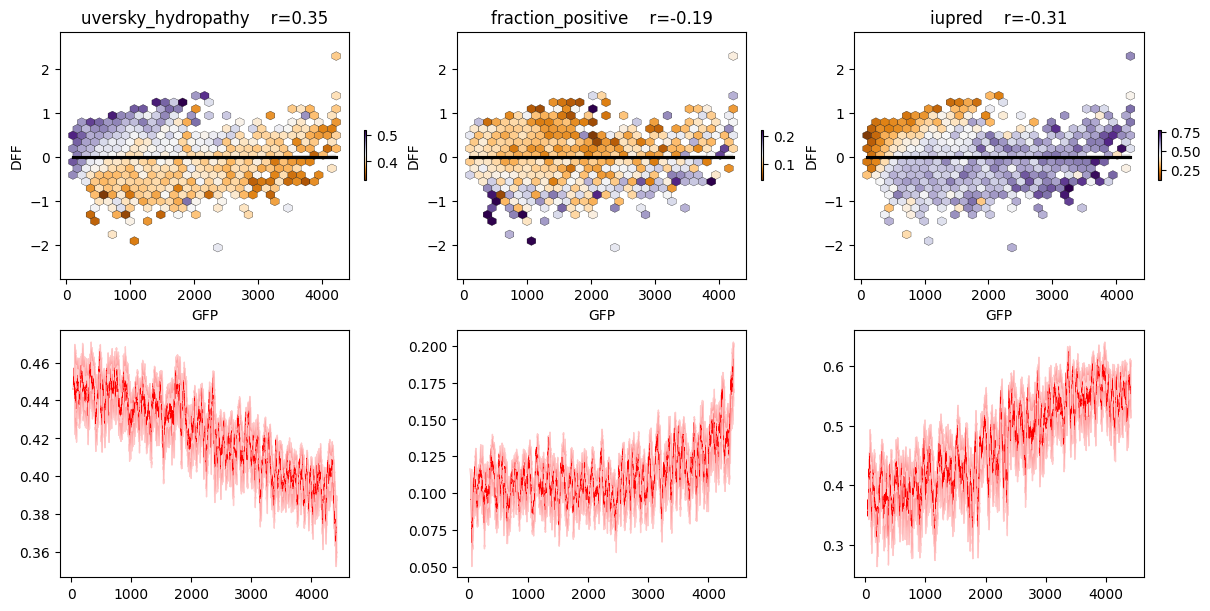

In [80]:
params = ["uversky_hydropathy" ,"fraction_positive","iupred"]
rolling_window = 30
tiling_cider_df = pd.read_csv(os.path.join(curr_dir,'csv_files/tiling_cider.csv'),index_col=0)
tiling_cider_df['GFP_mean'] = tiling_seqs['GFP_mean']
tiling_cider_df['distanceFromFit'] = tiling_seqs['distanceFromFit']
tiling_cider_df = tiling_cider_df.dropna()

fig,axes=plt.subplots(2,3,figsize=(12,6),layout='constrained')
# tiling_cider_df = tiling_cider_df.dropna()
for i,param in enumerate(params):
    ax = axes.ravel()[i]
    x = tiling_cider_df['GFP_mean']
    y = tiling_cider_df['distanceFromFit']
    z = tiling_cider_df[param]

    hb = ax.hexbin(x, y, C=z,gridsize=30,mincnt=1,edgecolors ='k',linewidths=.2)
    current_vmax = hb.get_array().max()
    current_vmin = hb.get_array().min()
    new_vmax = current_vmax #* (1 - reduction_factor_max)
    new_vmin = current_vmin #* (1 + reduction_factor_min)
    ax.cla()
    
    if param == 'fraction_positive':
        new_vmax=.22
        
    a = sns.regplot(data=tiling_cider_df, x="GFP_mean", y="distanceFromFit",color='k',ax=ax,scatter=False)
    hb = ax.hexbin(x, y, C=z, gridsize=30, cmap='PuOr', mincnt=1,
                      edgecolors='k', linewidths=.2, vmin=new_vmin, vmax=new_vmax)
    plt.colorbar(hb,shrink=0.2)
    ax.set_xlabel('GFP')
    ax.set_ylabel('DFF')
    ax.set_title(param + '    r=' + str(np.round(z.corr(y),2)))

    ax = axes.ravel()[i+3]
    sorted_array = tiling_cider_df.sort_values(by=['distanceFromFit'],ascending=False)[param].dropna()
    ax.plot(range(len(sorted_array)), sorted_array.rolling(window=rolling_window).mean(), color='r',linewidth = .2)
    ax.fill_between(range(len(sorted_array)), sorted_array.rolling(window=rolling_window).mean() - sorted_array.rolling(window=50).sem()*2,
                     sorted_array.rolling(window=50).mean() + sorted_array.rolling(window=50).sem() *2, color='r', alpha=0.2)
    


Text(0.5, 0, 'Peptide middle')

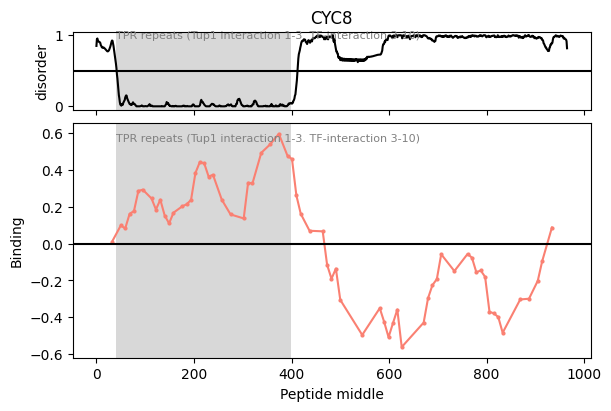

In [82]:
#plot Cyc8 example
tf = 'CYC8'
window_size = 5
sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == tf.upper()].dropna(subset=['distanceFromFit'])
sub_tiling_df['MetaPredict'] = tiling_cider_df.loc[sub_tiling_df.index,'MetaPredict']
fig,axes = plt.subplots(2,1,figsize=(6,4),height_ratios=[1,3],sharex=True,constrained_layout = True)
dis_pred =  np.loadtxt(os.path.join(curr_dir,'metapredict_disorder_full_tfs/CYC8.txt'))

axes[0].plot(dis_pred,c='k')
markDomains(tf.upper(),axes[0])
axes[0].set_ylabel('disorder')
axes[0].set_title(tf.upper())
axes[0].axhline(y=0.5,c='k')


y_value = pd.Series(sub_tiling_df['distanceFromFit']).rolling(window=window_size, min_periods=1,center=True).mean()
axes[1].plot(sub_tiling_df['pep_middle'],y_value,c='salmon',marker='o',markersize = 2)        
axes[1].axhline(y=0,c='k')
axes[1].set_ylabel('Binding')
markDomains(tf.upper(),axes[1]) 
axes[1].set_xlabel('Peptide middle')


Text(0.1, -0.7, 'R= -0.61')

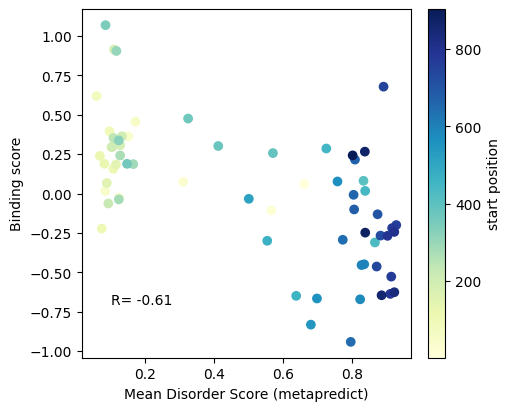

In [83]:
fig,axes = plt.subplots(1,1,figsize=(5,4),constrained_layout = True)
plt.scatter(sub_tiling_df['MetaPredict'],sub_tiling_df['distanceFromFit'],c = sub_tiling_df['pep_start'],cmap='YlGnBu')
cbar = plt.colorbar()
cbar.set_label('start position')
plt.xlabel('Mean Disorder Score (metapredict)')
plt.ylabel('Binding score')
plt.text(.1,-0.7,'R= ' + str(round(sub_tiling_df['distanceFromFit'].corr(sub_tiling_df['MetaPredict']),2)))


In [86]:
#find if a peptide is DBD
DomainDesc = pd.read_csv(os.path.join(curr_dir,'supp_tables/Table_S1_Domains.csv'),index_col=0)
DomainDesc = remove_similar_peps(DomainDesc,20)

isDBD = []
#
for i,row in tiling_seqs.iterrows():
    curr_dbd = DomainDesc[DomainDesc['TF_name'] == row['TF_name']]
    if not curr_dbd.empty:
        curr_dbd_len = curr_dbd['OriginalEndPos'][0] - curr_dbd['OriginalStartPos'][0]
        if row['pep_start']  < (curr_dbd['OriginalEndPos'][0] - curr_dbd_len/2) and row['pep_end']> (curr_dbd['OriginalStartPos'][0] + curr_dbd_len/2):
            isDBD.append(1)
        else:
            isDBD.append(0)
    else:
        isDBD.append(0)
tiling_seqs['isDBD_loc'] = isDBD


Text(0.5, 1.0, 'nonDBD- ordered')

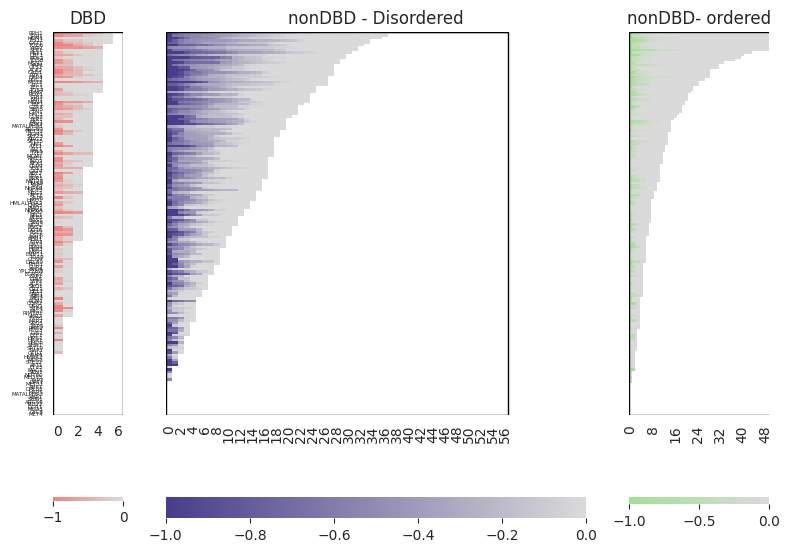

In [87]:


tiling_seqs.loc[tiling_cider_df.index,'iupred'] =  tiling_cider_df['iupred']
tiling_seqs.loc[tiling_cider_df.index,'MetaPredict'] =  tiling_cider_df['MetaPredict']


# tiling_seqs_notna =  tiling_seqs.dropna(by='distanceFromFit')
all_tfs = tiling_seqs['TF_name'].value_counts().index.to_list()
reversed_map=plt.colormaps.get_cmap('Blues').reversed() 

tf_dict = dict()
dbd_dict = dict()
nonDBD_dis_dict = dict()
nonDBD_struct_dict = dict()

x_corr = []
y_corr = []
width_len = []
minVal = -2.5
maxVal = 0

treshold_disordered = 0.5
c=0
for c, tf in enumerate(all_tfs):

    sub_df = tiling_seqs[tiling_seqs['TF_name'] == tf]     
    dbd_peps = pd.Series(sub_df['distanceFromFit'].loc[sub_df['isDBD_loc'] == 1].sort_values().values)   
    # dbd_peps = pd.Series(sub_df['distanceFromFit'].loc[sub_df['interpro_general_description'] == 'DBD'].sort_values().values)    
    nonDBD_dis_peps = pd.Series(sub_df[(sub_df['isDBD_loc'] == 0) & (sub_df['iupred'] > treshold_disordered)]['distanceFromFit'].sort_values().values)        
    nonDBD_struct_peps = pd.Series(sub_df[(sub_df['isDBD_loc'] == 0) & (sub_df['iupred'] < treshold_disordered)]['distanceFromFit'].sort_values().values)

    averages = pd.concat([dbd_peps, nonDBD_dis_peps, nonDBD_struct_peps], axis=0)
    tf_dict[tf] = averages.reset_index()[0]
    dbd_dict[tf] = dbd_peps.reset_index()[0]
    nonDBD_dis_dict[tf]= nonDBD_dis_peps.reset_index()[0]
    nonDBD_struct_dict[tf]= nonDBD_struct_peps.reset_index()[0]
            
sns.set_style("white")
fig,axes = plt.subplots(1,3,figsize=(8,6),width_ratios=[1, 6,2])
plt.subplots_adjust(wspace=0.001)

sort_order = pd.DataFrame(dbd_dict).isna().sum().sort_values(ascending=True).index
ax = sns.heatmap(pd.DataFrame(dbd_dict).T.loc[sort_order],yticklabels=True,ax=axes[0],cmap=sns.blend_palette(["#EE8481","#DADADA"],as_cmap = True),vmin=-1,vmax=0, cbar_kws={"orientation": "horizontal", "location": "bottom"})
rect = patches.Rectangle((0, 0), pd.DataFrame(dbd_dict).T.shape[1], pd.DataFrame(dbd_dict).T.shape[0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.set_title('DBD')
ax.set_yticklabels(ax.get_yticklabels(), size=4)

sort_order = pd.DataFrame(nonDBD_dis_dict).isna().sum().sort_values(ascending=True).index
ax = sns.heatmap(pd.DataFrame(nonDBD_dis_dict).T.loc[sort_order],yticklabels=False,ax=axes[1],cmap=sns.blend_palette(["darkslateblue","#DADADA"],as_cmap = True),vmin=-1,vmax=0, cbar_kws={"orientation": "horizontal", "location": "bottom"})
#ax.set_facecolor("#FFFFFF")
rect = patches.Rectangle((0, 0), pd.DataFrame(nonDBD_dis_dict).T.shape[1], pd.DataFrame(nonDBD_dis_dict).T.shape[0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.set_title('nonDBD - Disordered')
ax.set_xlim([0,70])


sort_order = pd.DataFrame(nonDBD_struct_dict).isna().sum().sort_values(ascending=True).index
ax = sns.heatmap(pd.DataFrame(nonDBD_struct_dict).T.loc[sort_order],yticklabels=False,ax=axes[2],cmap=sns.blend_palette(["#A3E094","#DADADA"],as_cmap = True) ,vmin=-1,vmax=0, cbar_kws={"orientation": "horizontal", "location": "bottom"})
rect = patches.Rectangle((0, 0), pd.DataFrame(nonDBD_struct_dict).T.shape[1], pd.DataFrame(nonDBD_struct_dict).T.shape[0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.set_xlim([0,50])
ax.set_title('nonDBD- ordered')




DBD
nonDBD_disordered
nonDBD_ordered


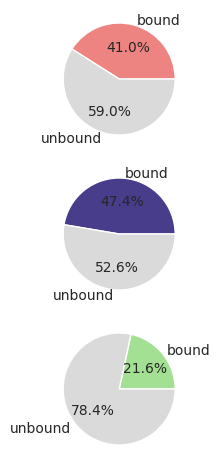

In [88]:
#plot pie chart

array_data = pd.DataFrame(dbd_dict).values.flatten()
dbd_array = pd.DataFrame(array_data[~np.isnan(array_data)],columns = ['FC'])
dbd_array['region'] = 'DBD'

array_data = pd.DataFrame(nonDBD_dis_dict).values.flatten()
nonDis_array = pd.DataFrame(array_data[~np.isnan(array_data)],columns = ['FC'])
nonDis_array['region'] = 'nonDBD_disordered'

array_data = pd.DataFrame(nonDBD_struct_dict).values.flatten()
nonStru_array = pd.DataFrame(array_data[~np.isnan(array_data)],columns = ['FC'])
nonStru_array['region'] = 'nonDBD_ordered'


a = pd.concat([dbd_array, nonDis_array, nonStru_array],axis=0)
a['bound'] = a['FC']<-.15 

colors = [
    ["#EE8481", "#DADADA"]  ,
    ["darkslateblue","#DADADA"]  ,
    [ "#A3E094","#DADADA"]]

stats_df = pd.DataFrame(a.groupby('region')['bound'].mean())
stats_df['unbound'] = 1 - stats_df['bound']

fig,ax = plt.subplots(3,1)
for i, row in enumerate(stats_df.index):
    print(row)
    ax[i].pie(stats_df.T.iloc[:,i],colors = colors[i],labels=stats_df.T.index,autopct='%1.1f%%')




droping samples[3]
droping samples[2]
droping samples[1]
droping samples[1]
droping samples[1]
droping samples[1]
droping samples[4]
droping samples[3, 4, 10]
droping samples[10]


(0.0, 1.0)

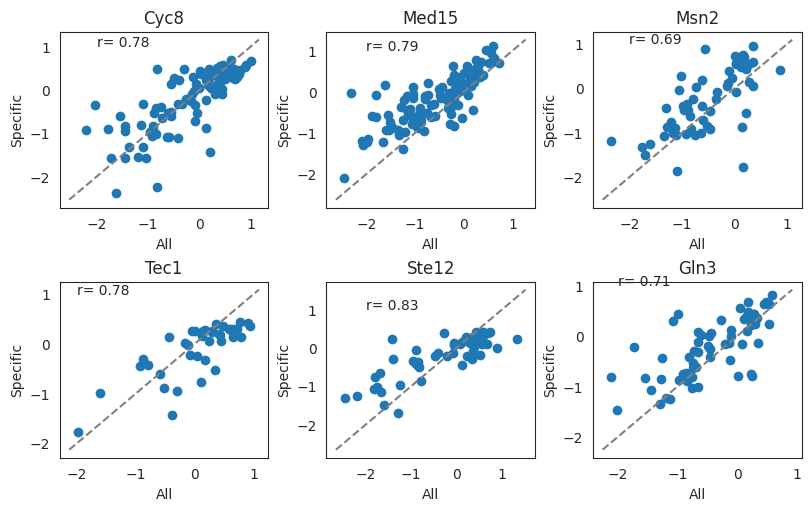

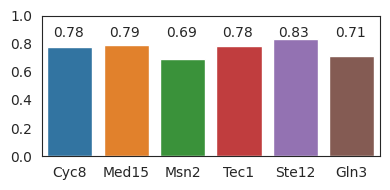

In [89]:
# Compare specific tiling to all tiling
strain = 'BY'
exp_prom = 'TEF1'
# lib = 'CYC8'

csv_files = sorted(os.listdir(os.path.join(curr_dir,'../res_files/')), key=str.casefold)

lib = ['Cyc8','Med15','Msn2','Tec1','Ste12','Gln3']
fig,axes = plt.subplots(2,3,figsize=(8,5),constrained_layout = True)
corr_vec = []

for c, tf in enumerate(lib): 
    curr_ax = axes.ravel()[c]
    rel_files = [file for file in csv_files if '_'.join(['BY','TEF1',tf]) in file]
    rel_files = [item for item in rel_files if "GFP" not in item and "promUpstream" not in item]

    # if not rel_files:
    #     continue

    comb_df = pd.DataFrame()
    for curr_file in rel_files:
        # df = pd.read_csv(os.path.join(folder_path, curr_file),index_col=0)
        df = normReads(curr_file,meta_df)
        df = normTP0(df)
       # df = df.add_prefix(curr_file)
        df = df.filter(regex='360',axis=1)
        comb_df = pd.concat([comb_df,df],axis=1)
    comb_df.index = comb_df.index.str.upper()
    comb_df['median_FC'] = comb_df.median(axis=1)
    comb_df['pep_start'] = comb_df.index.str.split('_').str.get(1).astype(int)
    comb_df['pep_end'] = comb_df.index.str.split('_').str.get(2).astype(int)
    comb_df['TF_name'] = comb_df.index.str.split('_').str.get(0)
    comb_df = comb_df[comb_df['TF_name'] == tf.upper()]
    res_df = pd.DataFrame()


    sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == tf.upper()]

    pep_name = []
    pep_FC = []
    for i, row in sub_tiling_df.iterrows():   
        closest_row = comb_df.loc[(np.abs(comb_df['pep_start'] - row['pep_start'])).idxmin()]
        # pep_name.append(closest_row.name)
        # pep_FC.append(closest_row['median_360_FC'])

        a = pd.DataFrame({'tilingAll pep': [row.name], 'FC_all' : [row['median_FC']], 'tilingSpecific': [closest_row.name], 'FC_specific' : [closest_row['median_FC']]})
        res_df = pd.concat([res_df, a],axis=0)
    res_df = res_df.reset_index().drop(columns='index')
    # res_df = pd.concat([res_df,pd.DataFrame(domain_included,columns=['domain_included'])],axis=1)

    # res_df['distance'] = np.abs(res_df['Domain pep'].apply(lambda x: int(x.split('_')[1]))  - res_df['tiling pep'].apply(lambda x: int(x.split('_')[1])))


    curr_ax.scatter(res_df['FC_all'],res_df['FC_specific'])
    corr_vec.append(res_df['FC_all'].corr(res_df['FC_specific']))
    curr_ax.set_xlabel('All')
    curr_ax.set_ylabel('Specific')
    curr_ax.set_title(tf)
    
    lims = [
    np.min([curr_ax.get_xlim(), curr_ax.get_ylim()]),  
    np.max([curr_ax.get_xlim(), curr_ax.get_ylim()]),  
    ]
    
    curr_ax.plot(lims,lims, linestyle='--', color='gray', label='x=Y')
    curr_ax.text(-2,1,'r= ' + str(round(res_df['FC_all'].corr(res_df['FC_specific']),2)))
fig,ax=plt.subplots(1,1,figsize=(4,2))
sns.barplot(pd.DataFrame(corr_vec,index=lib,columns=['corr general-specific']).T)
for i,val in enumerate(corr_vec):
    plt.text(i-.3,0.85,np.round(val,2))
ax.set_ylim(0,1)



droping samples[3]
droping samples[1]
droping samples[1]
droping samples[1]
droping samples[1]
droping samples[2]
droping samples[4]
droping samples[3, 4, 10]
droping samples[10]


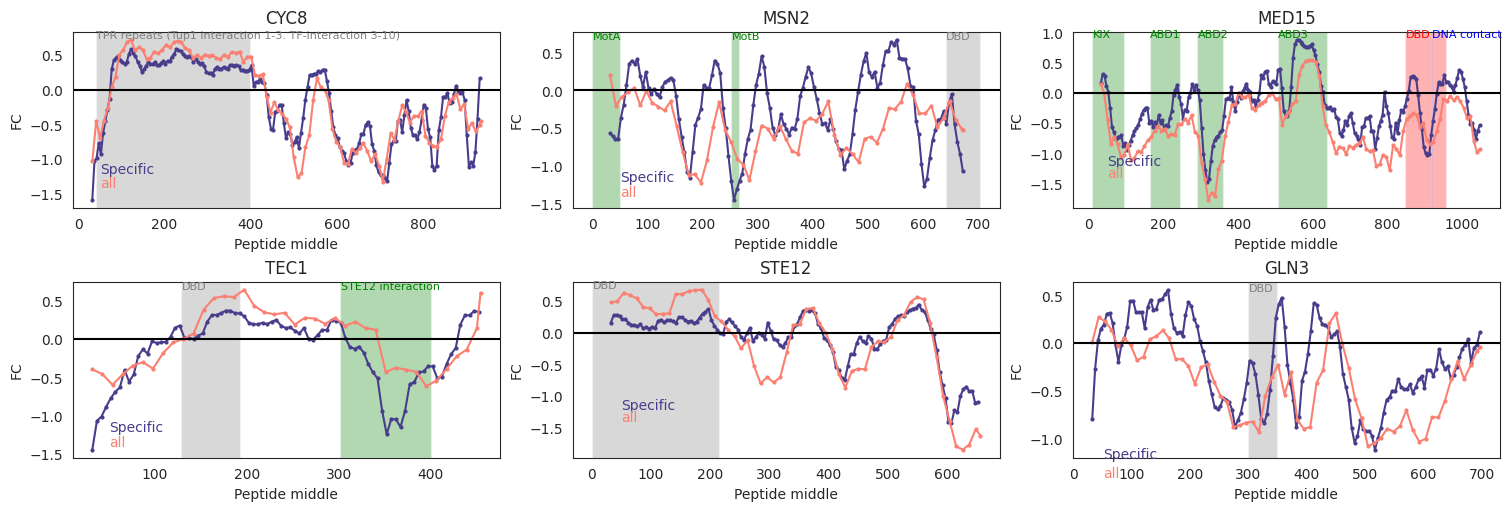

In [90]:
# Compare specific tiling to all tiling
strain = 'BY'
exp_prom = 'TEF1'
window_size = 5
folder_path = os.path.join(curr_dir,'../res_files/')

lib = ['Cyc8','Msn2','Med15','Tec1','Ste12','Gln3']
#lib = ['Med15']
fig,axes = plt.subplots(2,3,figsize=(15,5),constrained_layout = True)

for c, tf in enumerate(lib): 
    curr_ax = axes.ravel()[c]
    rel_files = [file for file in csv_files if '_'.join(['BY','TEF1',tf]) in file]
    rel_files = [item for item in rel_files if "GFP" not in item and "promUpstream" not in item]

    comb_df = pd.DataFrame()
    for curr_file in rel_files:
        df = normReads(curr_file,meta_df)
        df = normTP0(df)
        df = df.filter(regex='360',axis=1)
        comb_df = pd.concat([comb_df,df],axis=1)
    comb_df.index = comb_df.index.str.upper()
    comb_df['median_FC'] = comb_df.median(axis=1)
    comb_df['pep_start'] = comb_df.index.str.split('_').str.get(1).astype(int)
    comb_df['pep_end'] = comb_df.index.str.split('_').str.get(2).astype(int)
    comb_df['pep_middle'] =  comb_df['pep_end'] - ((comb_df['pep_end'] - comb_df['pep_start'] +1)/2 )
    comb_df['TF_name'] = comb_df.index.str.split('_').str.get(0)
    comb_df = comb_df[comb_df['TF_name'] == tf.upper()]

    sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == tf.upper()]
        
    curr_ax.plot(comb_df['pep_middle'],pd.Series(comb_df['median_FC']).rolling(window=window_size, min_periods=1).mean(),
                 c = 'darkslateblue',marker='o',markersize = 2)

    curr_ax.plot(sub_tiling_df['pep_middle'],pd.Series(sub_tiling_df['median_FC']).rolling(window=window_size, min_periods=1).mean(),
                 c = 'salmon',marker='o',markersize = 2)

    # curr_ax.plot(sub_tiling_df['pep_middle'],pd.Series(sub_tiling_df['distanceFromFit']).rolling(window=window_size, min_periods=1).mean(),
    #              c = 'k',marker='o',markersize = 2)

    curr_ax.axhline(y=0,c='k')
    curr_ax.set_xlabel('Peptide middle')
    curr_ax.set_ylabel('FC')
    curr_ax.set_title(tf.upper())
    markDomains(tf.upper(),curr_ax)
    curr_ax.text(50,-1.2,'Specific',color='darkslateblue')
    curr_ax.text(50,-1.4,'all',color='salmon')



In [ ]:
# data = {
#     'peptide': ['pep1', 'pep2', 'pep3', 'pep4', 'pep5', 'pep6', 'pep7'],
#     'start': [4, 134, 209, 319, 421, 569, 376],
#     'end': [64, 194, 269, 379, 481, 629, 436]
# }

# msn2_peps_location = pd.DataFrame(data)
# msn2_peps_location.drop(msn2_peps_location.tail(1).index,inplace=True) #Drop peptide 7?

# y_loc = [1.4,1.95,2.2,1.5,1.9,2.3,0.7]
# for i, row in msn2_peps_location.iterrows():
#     plt.hlines(y=y_loc[i], xmin=row['start'], xmax=row['end'], color='k',linewidths = 3)
#     plt.text(row['start']+5,y_loc[i]+0.1, row['peptide'], color='k', ha='left', va='center')

droping samples[1]
droping samples[1]
droping samples[1]
droping samples[1]


Text(0.5, 1.0, 'GFP distribution')

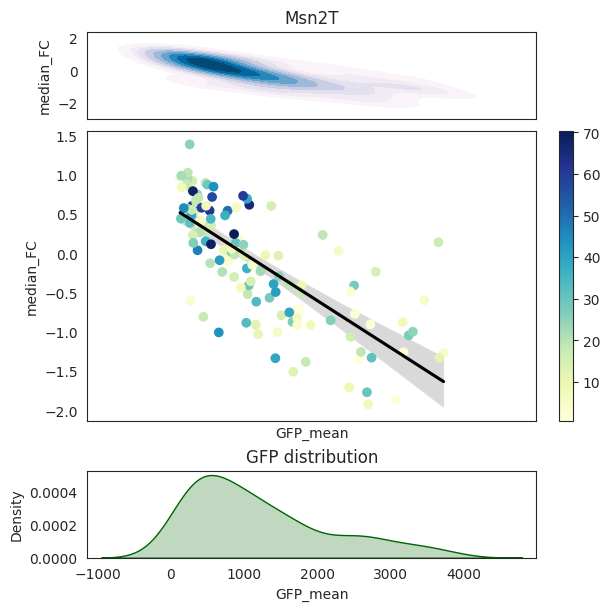

In [835]:
# # calculate Msn2T FC, GFP, distance from fit along the protein

# params = ['median_360_FC','GFP_mean','distanceFromFit']

# rel_files = [file for file in csv_files if '_'.join(['BY','TEF1','Msn2']) in file]
# rel_files = [item for item in rel_files if "GFP" not in item and "promUpstream" not in item]

# Msn2T_df = pd.DataFrame()
# for curr_file in rel_files:
#     df = pd.read_csv(os.path.join(folder_path, curr_file),index_col=0)
#     df = normReads(curr_file,meta_df)
#     df = normTP0(df)
#     df.index = df.index.str.upper()
#    # df = df.add_prefix(curr_file)
#     df = df.filter(regex='360',axis=1)
#     Msn2T_df = pd.concat([Msn2T_df,df],axis=1)
# # comb_df.index = comb_df.index.str.upper()
# Msn2T_df['median_FC'] = Msn2T_df.median(axis=1)
# Msn2T_df['pep_start'] = Msn2T_df.index.str.split('_').str.get(1).astype(int)
# Msn2T_df['pep_end'] = Msn2T_df.index.str.split('_').str.get(2).astype(int)
# Msn2T_df['pep_middle'] =  Msn2T_df['pep_end'] - ((Msn2T_df['pep_end'] - Msn2T_df['pep_start'] +1)/2 )
# Msn2T_df['TF_name'] = Msn2T_df.index.str.split('_').str.get(0)

# #cal GFP and distance from fit
# Msn2T_df, GFP_df, gfp_bins = cal_GFP(Msn2T_df,'Msn2T',4,1000)
# # Msn2T_df = Msn2T_df[Msn2T_df['GFPstd'] <= 1500]
# # Msn2T_df = Msn2T_df[Msn2T_df['GFP_mean']>0]
# Msn2T_df,_ = cal_dis_from_fit(Msn2T_df,"GFP_mean","median_FC")
# Msn2T_df['pep_type'] = Msn2T_df.index.to_series().apply(lambda idx: 'control' if 'HXK1' in idx or 'GSY1' in idx or 'TDH3' in idx else ('WT' if 'wt' in idx else 'tile'))
# Msn2T_df.index = Msn2T_df.index.map(lambda x: '_'.join(x.split('_')[:2]))
# Msn2T_df['lib_type'] = 'Msn2T'
# Msn2T_df = rotate_axis(Msn2T_df,'GFP_mean','median_FC')


# x = Msn2T_df['GFP_mean'].values[:,np.newaxis]
# y = Msn2T_df['median_FC']

# # fig,axes = plt.subplots(1,1)
# fig,axes = plt.subplots(3,1,figsize=(6,6),height_ratios=(3,10,3),layout='constrained',sharex=True)
# axes[0].set_title('Msn2T')

# #plot1
# den_plot = sns.kdeplot(data = Msn2T_df,x = 'GFP_mean',y="median_FC",cmap='PuBu',fill=True,ax=axes[0])
# #plot2
# sns.regplot(data=Msn2T_df, x="GFP_mean", y="median_FC",color='k',scatter=False,ax=axes[1])
# scp = axes[1].scatter(x,y,c=Msn2T_df['GFP_CV'],cmap='YlGnBu')
# plt.colorbar(scp)
# #plot3
# sns.kdeplot(data=Msn2T_df, x="GFP_mean",color='darkgreen',ax=axes[2],fill=True)
# axes[2].set_title('GFP distribution')

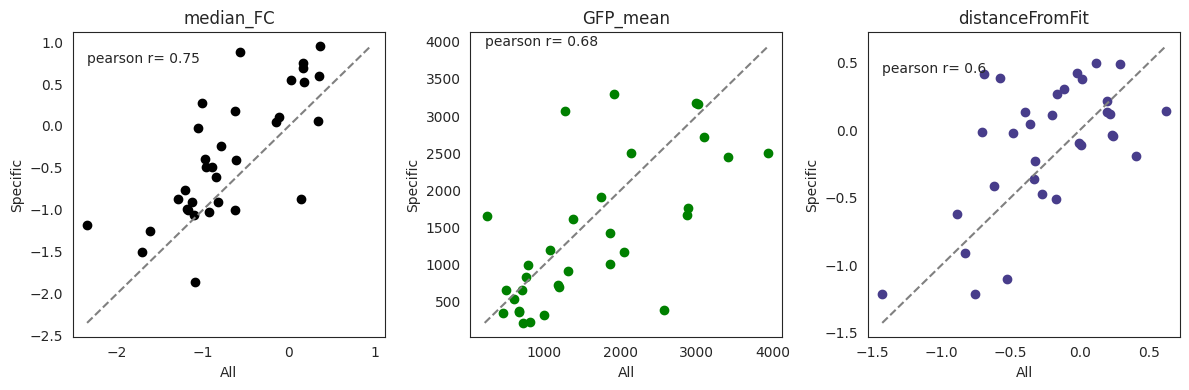

In [851]:
# # Compare specific tiling to all tiling
# colors = ['k','green','darkslateblue']
# params = ["median_FC","GFP_mean","distanceFromFit"]
# tresh_numReads=4
# res_df = pd.DataFrame()

# sub_tiling_df = tiling_seqs[tiling_seqs['TF_name'] == 'MSN2']
# sub_tiling_df = sub_tiling_df.loc[sub_tiling_df['distanceFromFit']<1] # remove out outlier

# pep_name = []
# pep_FC = []
# for i, row in sub_tiling_df.iterrows():   
#     closest_row = Msn2T_df.loc[(np.abs(Msn2T_df['pep_start'] - row['pep_start'])).idxmin()]

#     a = pd.DataFrame({'tilingAll pep': [row.name],  'tilingSpecific': [closest_row.name],'median_FC_all' : [row['median_FC']], 'median_FC_specific' : [closest_row['median_FC']],
#                      'GFP_mean_all' : [row.GFP_mean],'GFP_mean_specific': [closest_row['GFP_mean']],
#                      'distanceFromFit_all' : [row.distanceFromFit],'distanceFromFit_specific': [closest_row['distanceFromFit']]})
#     res_df = pd.concat([res_df, a],axis=0)
# res_df = res_df.reset_index().drop(columns='index')
# # res_df = pd.concat([res_df,pd.DataFrame(domain_included,columns=['domain_included'])],axis=1)
# # res_df['distance'] = np.abs(res_df['Domain pep'].apply(lambda x: int(x.split('_')[1]))  - res_df['tiling pep'].apply(lambda x: int(x.split('_')[1])))

# fig,axes = plt.subplots(1,3,figsize=(12,4))
# for i,param in enumerate(params):
#     curr_ax = axes.ravel()[i]
#     curr_ax.scatter(res_df[param+'_all'],res_df[param+'_specific'],c=colors[i])
#     curr_ax.set_xlabel('All')
#     curr_ax.set_ylabel('Specific')
#     curr_ax.set_title(param)
#     minVal = res_df.loc[:,[param+'_all',param+'_specific']].min(axis=0).values.min()
#     maxVal = res_df.loc[:,[param+'_all',param+'_specific']].max(axis=0).values.max()
#     curr_ax.plot([minVal, maxVal], [minVal, maxVal], linestyle='--', color='gray', label='x=Y')
#     curr_ax.text(minVal,maxVal-0.2,'pearson r= ' + str(round(res_df[param+'_all'].corr(res_df[param+'_specific'],method='pearson'),2)))
# plt.savefig('/home/labs/barkailab/offirlu/pepLib/Paper/Fig4_new/supp/compareAlltoSpecific.pdf', format="pdf", bbox_inches="tight")

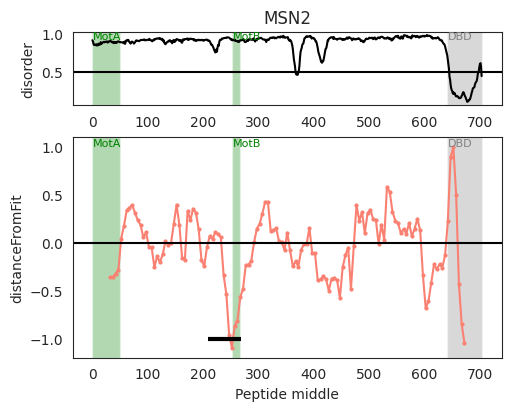

In [850]:
# # plot distance from fit
# window_size = 3
# fig,axes = plt.subplots(2,1,figsize=(5,4),height_ratios=[1,3],constrained_layout = True)

# #plot
# temp_df = Msn2T_df[Msn2T_df['pep_type'] == 'tile']
# dis_pred =  np.loadtxt('/home/labs/barkailab/offirlu/pepLib/metapredict/full_tfs/MSN2.txt')
# axes[0].plot(dis_pred,c='k')
# markDomains('MSN2',axes[0])
# axes[0].set_ylabel('disorder')
# axes[0].set_title('MSN2')
# axes[0].axhline(y=0.5,c='k')

# y_value = pd.Series(temp_df['distanceFromFit']).rolling(window=window_size, min_periods=1).mean()
# axes[1].plot(temp_df['pep_middle'],y_value,c='salmon',marker='o',markersize = 2)        
# axes[1].axhline(y=0,c='k')
# axes[1].set_ylabel(param)
# markDomains('MSN2',axes[1])
# axes[1].set_xlabel('Peptide middle')

# msn2_peps_location = pd.DataFrame(data)
# axes[1].hlines(y=-1, xmin=209, xmax=269, color='k',linewidths = 3)


# plt.savefig('/home/labs/barkailab/offirlu/pepLib/Paper/Fig5/Msn2Tiling.pdf', format="pdf", bbox_inches="tight")

In [982]:
from Bio.Seq import Seq
df  = pd.read_csv('/home/labs/barkailab/offirlu/pepLib/Paper/tables/specific_libs.csv',index_col='name')
df['peptide_sequence'] = df['sequence'].apply(lambda x: str(Seq(x[18:-18]).translate()))
df.to_csv('/home/labs/barkailab/offirlu/pepLib/Paper/tables/specific_libs_new.csv')
# curr_seq = Seq(df['sequence'][0][18:-18])
# len(str(curr_seq))
# len(str(curr_seq.translate()))